<a href="https://colab.research.google.com/github/iptkachev/dls_part1/blob/master/%5Bhw%5Dgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [227]:
import os
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torchvision.utils as vutils
from pathlib import Path
from PIL import Image
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [17]:
# !gdown --id 1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9 && unzip -qq /content/faces_dataset_small.zip

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
! unzip -qq /content/drive/MyDrive/faces_dataset_small.zip

In [228]:
class FacesDataset(Dataset):
  def __init__(self, root: str):
    super().__init__()
    self.file_paths = list(Path(root).rglob('*.png'))
    self.transform = tt.Compose([
      tt.Resize(image_size),
      tt.CenterCrop(image_size),
      tt.ToTensor(),
      tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

  def __getitem__(self, index):
    image = self._load_image(self.file_paths[index])
    return self.transform(image)

  def _load_image(self, path):
      image = Image.open(path)
      image.load()
      return image
  
  def __len__(self):
    return len(self.file_paths)

dataset = FacesDataset("/content/faces_dataset_small")

In [20]:
def get_dataloader(image_size, batch_size):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
  """
  # TODO: resize images, convert them to tensors and build dataloader
  dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
  return dataloader

In [21]:
image_size = 128
batch_size = 64

#TODO: build dataloader and transfer it to device
dataloader = get_dataloader(image_size, batch_size)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [233]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))


def plot_reconstruction(pred, n_examples=6, **kwargs_plot):
  clear_output(wait=True)
  plt.figure(figsize=(14, 10))
  plt.title('Generated pictures')
  for k in range(n_examples):
      plt.subplot(4, n_examples, k + 1)
      plt.imshow(pred[k].detach().cpu().numpy(), **kwargs_plot)
      plt.axis('off')

      plt.subplot(4, n_examples, k + (1 + n_examples))
      plt.imshow(pred[k + n_examples].detach().cpu().numpy(), **kwargs_plot)
      plt.axis('off')

      plt.subplot(4, n_examples, k + (1 + 2 * n_examples))
      plt.imshow(pred[k + 2 * n_examples].detach().cpu().numpy(), **kwargs_plot)
      plt.axis('off')


# Losses & scores
losses_g = []
losses_d = []
real_scores = []
fake_scores = []

def fit(dataloader, model, criterion, optimizer, epochs, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images in tqdm(dataloader):
            real_images = real_images.to(device)
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()
            
            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            # real_noise = torch.FloatTensor(*real_targets.shape).uniform_(0, 0.05)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            
            # Generate fake images and pass through discriminator
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            # fake_noise = torch.FloatTensor(*fake_targets.shape).uniform_(0, 0.05)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        normalized_fake_images = torch.permute(nn.Sigmoid()(fake_images), (0, 2, 3, 1))
        plot_reconstruction(normalized_fake_images)
        plt.suptitle(
            f"Epoch {epoch}: gen_loss {losses_g[-1]}, disc_loss {losses_d[-1]},"\
            f"real_score: {real_scores[-1]}, fake_score: {fake_scores[-1]}",
            fontsize=13
        )
        plt.show()
        plt.figure(figsize=(16, 7))
        plt.title("Losses")
        plt.plot(losses_g, label="generator")
        plt.plot(losses_d, label="discriminator")
        plt.legend()
        plt.show()

        # Save generated images
        if epoch == epochs - 1:
          save_samples(epoch+start_idx, fixed_latent, show=False)

In [238]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()
        self.classifier = nn.Sequential(
          # in: 3 x 64 x 64

          nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(64),
          nn.LeakyReLU(0.2, inplace=True),
          # out: 64 x 32 x 32

          nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(128),
          nn.LeakyReLU(0.2, inplace=True),
          # out: 128 x 16 x 16

          nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(256),
          nn.LeakyReLU(0.2, inplace=True),
          # out: 256 x 8 x 8

          nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(512),
          nn.LeakyReLU(0.2, inplace=True),
          # out: 512 x 4 x 4

          nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(1024),
          nn.LeakyReLU(0.2, inplace=True),
          nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
          # out: 1 x 1 x 1

          nn.Flatten(),
          nn.Sigmoid()
      )
        
    def forward(self, x):
        output = self.classifier(x)
        return output


discriminator = Discriminator()

In [239]:
latent_size = 128 # choose latent size

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [240]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

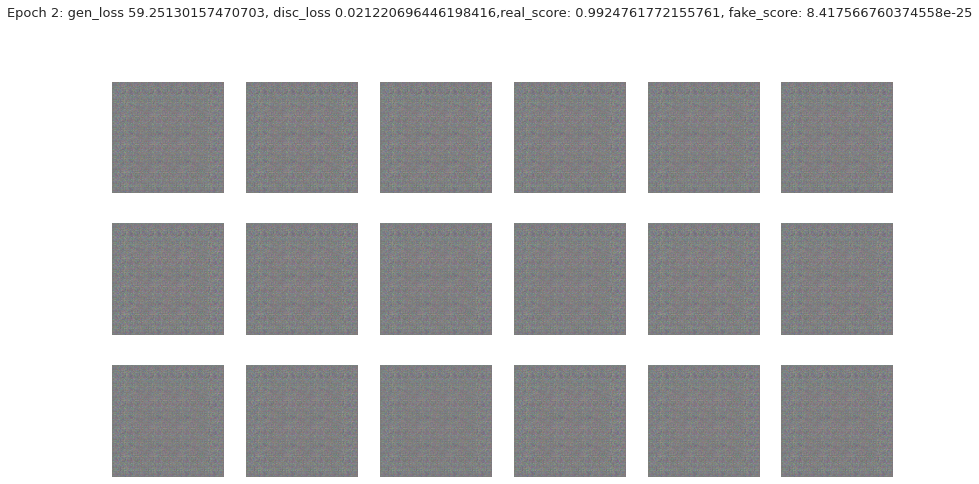

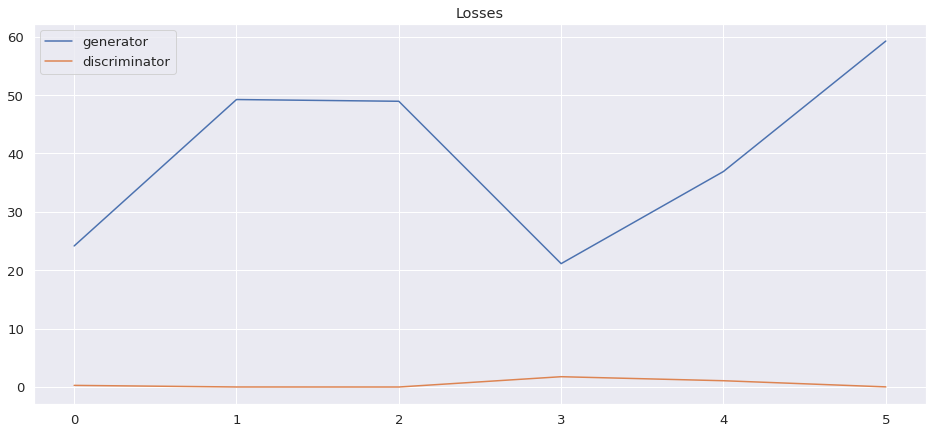

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
%%time

generator.apply(weights_init)
discriminator.apply(weights_init)

epochs = 30
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

optimizer = {
    "discriminator": torch.optim.Adam(
        model["discriminator"].parameters(), lr=0.0001, betas=(0.5, 0.999)
    ),
    "generator": torch.optim.Adam(
        model["generator"].parameters(), lr=0.0002, betas=(0.5, 0.999)
    )
}

fit(dataloader, model, criterion, optimizer, epochs)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [224]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [225]:
def show_images(generated):
  # TODO: show generated images
  plt.figure(figsize=(8,8))
  plt.axis("off")
  plt.title("Training Images")
  plt.imshow(np.transpose(vutils.make_grid(generated[:64], padding=2, normalize=True).cpu(),(1,2,0)))

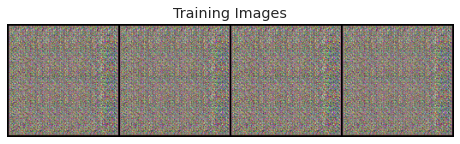

In [229]:
show_images(fake_images)

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

loo = LeaveOneOut()
knn = KNeighborsClassifier(n_neighbors=1)

print(cross_val_score(lasso, X, y, cv=loo.split()))

In [ ]:
X, y = [], []
for real_images in tqdm(dataloader):
  real_images = real_images.to(device)
  real_preds = model["discriminator"](fake_images)
  fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = model["generator"](fixed_latent)
  fake_preds = model["discriminator"](fake_images)

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

Прокомментируйте получившийся результат: